# Wizualizacja funkcji Rastrigina

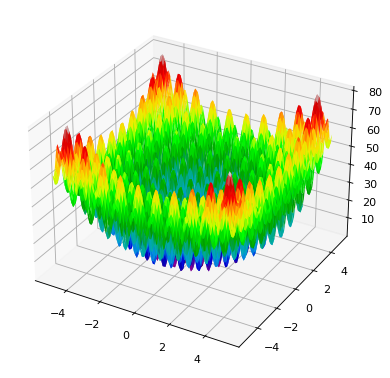

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

apply_tuple = lambda f: lambda args: f(*args)

@apply_tuple
def rastrigin(x,y):
    return (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y)) + 20

X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
 
fig = plt.figure(figsize=(8, 6), dpi=80) 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.savefig('rastrigin_graph.png')
plt.show()

# Kodowanie chromosomu

In [2]:
from functools import reduce
integerSize = 2
maxBitValue = -2**integerSize
def chromosome_to_xy(chromosome):
    x = reduce(lambda acc,x: (acc + 2**(integerSize-x[0])) if x[1] else acc,enumerate(chromosome[:chromosome.size//2]),maxBitValue)
    y = reduce(lambda acc,x: (acc + 2**(integerSize-x[0])) if x[1] else acc,enumerate(chromosome[chromosome.size//2:]),maxBitValue)
    return x,y

### Działanie
Stałe:

1) Rozmiar części całkowitej = 2, oznacza że pierwszy bit odpowiada wartości 2^2, a wszystkie kolejne niższym (2^1,2^0,2^-1, itd)

2) Rozmiar chromosomu, musi być liczbą parzystą ponieważ przechowuje dwie liczby

Przykład działania
Chromosom = [1,0,0,0,0,0,0,0]
Zostanie podzielony na dwie części:

* Pierwsza = [1,0,0,0]

* Druga = [0,0,0,0]

Po odczytaniu wartości

* Pierwsza = 1*2^2 + 0*2^1+ 0*2^0 + 0*2^(-1) = 4

* Druga = 0*2^2 + 0*2^1+ 0*2^0 + 0*2^(-1) = 0

Liczby są dodatkowo przesunięte o -2*Rozmiar_części_całkowitej, więc rezultamem są liczby:

* Pierwsza = 0
* Druga = -4

# Inicjalizacja populacji
Chromosom jest generowany w taki sposób, że 30% bitów ma wartość **0**, a pozostałe **1**. Po czym zostają losowo przemieszane.

In [3]:
import random
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

# Ocena osobnika
Ocena osobnika jest równa wartości przeciwnej do wyniku funkcji rastrigina dla danego osobnika. Co oznacza, żę minimum globalne odpowiada największej wartości oceny. 

In [4]:
def fitness_score(population):
    scores = np.array(list(map(lambda x: -rastrigin(chromosome_to_xy(x)), population)))
    population = np.array(population)
    order = np.argsort(-scores)
    return scores[order],population[order]

# Seleckcja elitystyczna
Wybieranych jest n_parents najlepszych osobników

In [5]:
def selection(pop_after_fit,n_parents):
    return np.array(pop_after_fit[:n_parents],copy=True)

# Krzyżowanie 
Z wyselekcjonowanej populacji osobniki są krzyżowane przy użyciu krzyżowania jednopunktowego.

In [6]:
def crossover(pop_after_sel):
    def crossingMethod(index):
        point = random.randint(0, len(pop_after_sel[0]))
        next_index = (index+1)%len(pop_after_sel)
        return np.concatenate((pop_after_sel[index][:point],pop_after_sel[next_index][point:]))
    return np.array([crossingMethod(index) for index in range(len(pop_after_sel))])

# Mutacja
Każdy bit ma mutation_rate szans by zostać zmutowany, poprzez odwrócenie wartości. 

In [7]:
def mutation(pop_after_cross,mutation_rate):
    mutated_data = np.array([[ (random.random() < mutation_rate) != x for x in chromosome] for chromosome in pop_after_cross])
    return np.concatenate((pop_after_cross,mutated_data))

# Główny przebieg algorytmu genetycznego

In [8]:
def generations(size,n_feat,n_parents,mutation_rate,n_gen):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

# Testowy pzrebieg programu

In [9]:
from operator import itemgetter
def plotScore(scores,bestindex):
    plt.figure(figsize=(8, 6), dpi=80) 
    plt.plot(scores)
    plt.scatter(bestindex, scores[bestindex],color="g",s=50)
    plt.annotate("best", (bestindex,scores[bestindex]))
    plt.ylabel('scores')
    plt.show()
    
def getBest(chromosomes,scores):
    best = max(zip(chromosomes,scores), key=itemgetter(1))
    bestindex = scores.index(best[1])
    return best,bestindex

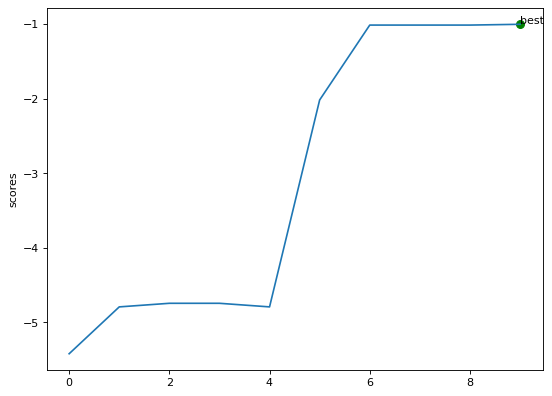

Final value[-0.002197265625,0.989990234375] = 1.000809743590704


In [10]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=40,n_feat=30,n_parents=20,mutation_rate=0.03,
                     n_gen=10)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x,y = chromosome_to_xy(best[0])
print(f"Final value[{x},{y}] = {rastrigin(chromosome_to_xy(best[0]))}")


Znalezione minimum to nie jest minimul globalne.

# Animacja najlepszych osobników

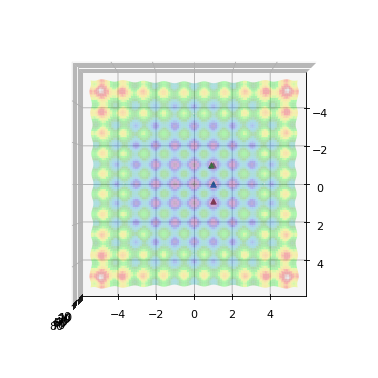

In [11]:
points = [chromosome_to_xy(ch) for ch in chromo]
x_r = [x[0] for x in points]
y_r = [x[1] for x in points]
z_r = [ rastrigin((x,y)) for x,y in points]
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 
Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
from IPython.display import HTML
from matplotlib import animation
frames = 200
fig = plt.figure(figsize=(8, 6), dpi=80) 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.nipy_spectral, linewidth=0.08,antialiased=True, alpha=0.3)    
ax.view_init(90, 0)
    
def animate(frame):
    start = len(x_r)*(frame-1)//frames
    end = len(x_r)*frame//frames
    if start != end:
        ax.scatter(x_r[start:end], y_r[start:end], z_r[start:end], marker="^")
#     plt.pause(.1)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=50)

HTML(anim.to_html5_video())

# Przebieg programu dla wysokiej mutacji

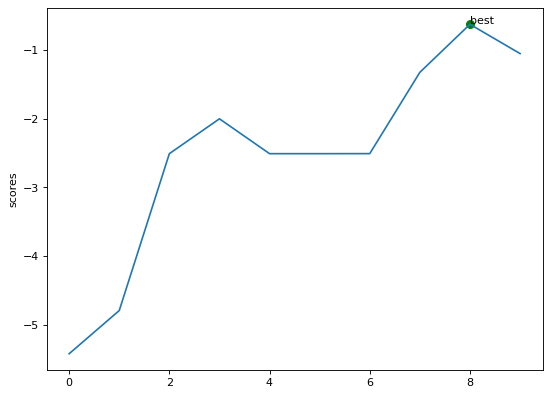

Final value[0.053466796875,-0.01806640625] = 0.6265411532841831


In [12]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=40,n_feat=30,n_parents=20,mutation_rate=0.3,
                     n_gen=10)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x,y = chromosome_to_xy(best[0])
print(f"Final value[{x},{y}] = {rastrigin(chromosome_to_xy(best[0]))}")

Znalezione minimum to minimum globalne, ale nie wyznaczone z dużą precyzją.

# Krzyżowanie przy użyciu średniej arytmetycznej

In [13]:
def crossover(pop_after_sel):
    def crossingMethod(curr_index):
        next_index = (curr_index+1)%len(pop_after_sel)
        carry = False
        child = []
        for bit_index in range(len(pop_after_sel[curr_index])-2,-1,-1):
            child.insert(0,(carry != pop_after_sel[curr_index][bit_index]) != pop_after_sel[next_index][bit_index])
            carry = (carry and pop_after_sel[curr_index][bit_index]) or (carry and pop_after_sel[next_index][bit_index]) or (pop_after_sel[curr_index][bit_index] and pop_after_sel[next_index][bit_index]) 
        child.insert(0,carry)
        return child
    return np.array([crossingMethod(index) for index in range(len(pop_after_sel))])

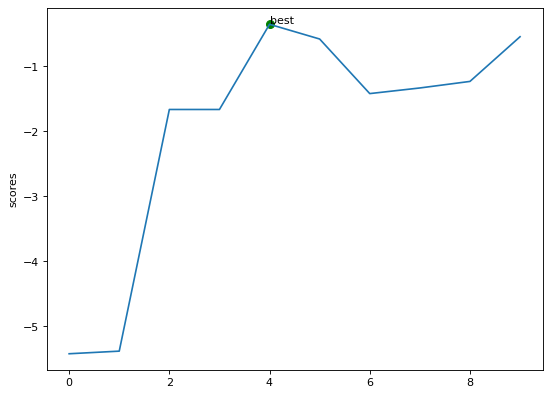

Final value[-0.028564453125,-0.031005859375] = 0.3515692453008583


In [14]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=40,n_feat=30,n_parents=20,mutation_rate=0.03,
                     n_gen=10)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x,y = chromosome_to_xy(best[0])
print(f"Final value[{x},{y}] = {rastrigin(chromosome_to_xy(best[0]))}")

Znalezione minimum to minimum globalne, ale nie wyznaczone z dużą precyzją.

# Krzyżowanie przy użyciu średniej arytmetycznej dwóch liczb niezależnie

In [15]:
def crossover(pop_after_sel):
    def crossingMethod(curr_index):
        next_index = (curr_index+1)%len(pop_after_sel)
        child = []
        half = len(pop_after_sel[curr_index])//2
        for start,end in [(len(pop_after_sel[curr_index])-2,half-1),(half-2,-1)]:
            carry = False
            for bit_index in range(start,end,-1):
                child.insert(0,(carry != pop_after_sel[curr_index][bit_index]) != pop_after_sel[next_index][bit_index])
                carry = (carry and pop_after_sel[curr_index][bit_index]) or (carry and pop_after_sel[next_index][bit_index]) or (pop_after_sel[curr_index][bit_index] and pop_after_sel[next_index][bit_index]) 
            child.insert(0,carry)
        return child
    return np.array([crossingMethod(index) for index in range(len(pop_after_sel))])

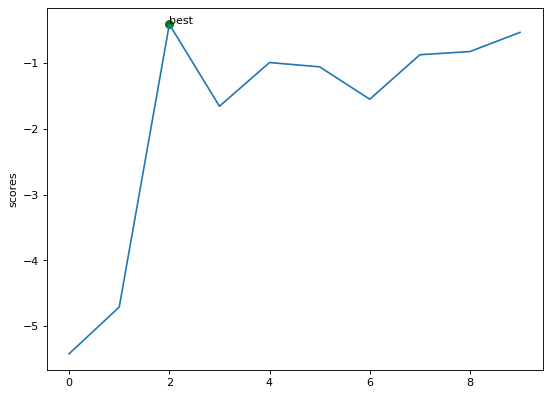

Final value[-0.044921875,0.007568359375] = 0.4090745616186524


In [18]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=40,n_feat=30,n_parents=20,mutation_rate=0.03,
                     n_gen=10)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x,y = chromosome_to_xy(best[0])
print(f"Final value[{x},{y}] = {rastrigin(chromosome_to_xy(best[0]))}")

Znalezione minimum to minimum globalne, ale nie wyznaczone z dużą precyzją.

# Wyniki

Zwykły znalazł minimum lokalne i się na nim zatrzymał
Z dużą mutacją znalazł globalne, ale nie poprawia wyniku
Średnia widocznie zaczeła poprawiać wynik